# Assignment 3 Data Analysis via Pandas

Get an experimentally informed connection matrix from from http://hippocampome.org/netlist
Or an excell spreadsheet of similar origin.

https://collab.humanbrainproject.eu/#/collab/5458/nav/42545


In [1]:


# Perform some system admin
import matplotlib.pyplot as plt

import os
import pandas as pd
import sys
import matplotlib as mpl
%matplotlib inline
mpl.rcParams.update({'font.size':16})
installs = ['bbp_client','neuron','mpi4py','xlrd','pyNN','seaborn','lazyarray','neo','neuron','brian2']
def install_deps(i):
  '''
  Hack in dependencies into to sys.path
  '''
  import os
  if i not in sys.path:
    os.system('pip install '+str(i))    

_ = list(map(install_deps,installs))
import os

#Compile NEUORN mod files.
temp = os.getcwd()
os.chdir('/opt/conda/lib/python3.5/site-packages/pyNN/neuron/nmodl')
!nrnivmodl
os.chdir(temp)







/opt/conda/lib/python3.5/site-packages/pyNN/neuron/nmodl
ProbAMPANMDA_EMS.mod ProbGABAAB_EMS.mod adexp.mod alphaisyn.mod alphasyn.mod expisyn.mod gammastim.mod gap.mod gif.mod gsfa_grr.mod hh_traub.mod izhikevich.mod netstim2.mod poisson_stim_refractory.mod quantal_stp.mod refrac.mod reset.mod stdwa_guetig.mod stdwa_softlimits.mod stdwa_songabbott.mod stdwa_symm.mod stdwa_vogels2011.mod stochastic_synapse.mod stochastic_tsodyksmarkram.mod tmgsyn.mod tmisyn.mod tsodyksmarkram.mod vecstim.mod
ProbAMPANMDA_EMS.mod ProbGABAAB_EMS.mod adexp.mod alphaisyn.mod alphasyn.mod expisyn.mod gammastim.mod gap.mod gif.mod gsfa_grr.mod hh_traub.mod izhikevich.mod netstim2.mod poisson_stim_refractory.mod quantal_stp.mod refrac.mod reset.mod stdwa_guetig.mod stdwa_softlimits.mod stdwa_songabbott.mod stdwa_symm.mod stdwa_vogels2011.mod stochastic_synapse.mod stochastic_tsodyksmarkram.mod tmgsyn.mod tmisyn.mod tsodyksmarkram.mod vecstim.mod
"/home/jovyan/nrn-7.4/share/nrn/libtool" --tag=CC --mode=compile 

In [2]:
# Get some hippocampus connectivity data, based on a conversation with
# academic researchers on GH:
# https://github.com/Hippocampome-Org/GraphTheory/issues?q=is%3Aissue+is%3Aclosed
# scrape hippocamome connectivity data, that I intend to use to program neuromorphic hardware.
# conditionally get files if they don't exist.

path_xl = '_hybrid_connectivity_matrix_20171103_092033.xlsx'
if not os.path.exists(path_xl):
    os.system('wget https://github.com/Hippocampome-Org/GraphTheory/files/1657258/_hybrid_connectivity_matrix_20171103_092033.xlsx')

xl = pd.ExcelFile(path_xl)
dfEE = xl.parse()
dfEE.loc[0].keys()
dfm = dfEE.as_matrix()
filtered = dfm[:,3:]
filtered = filtered[1:]



In [3]:

import numpy as np
from pyNN.neuron import STDPMechanism
import copy
EElist = []
IIlist = []
from pyNN.random import RandomDistribution, NumpyRNG

rng = NumpyRNG(seed=64754)
delay_distr = RandomDistribution('normal', [35, 1e-3], rng=rng)

for i,j in enumerate(filtered):
  
  for k,xaxis in enumerate(j):
    if xaxis==1 or xaxis ==2:
      source = i
      target = k
      delay = delay_distr.next()
      weight = 11.0
      IIlist.append((source,target,delay,weight))
        
    if xaxis==-1 or xaxis ==-2:
      source = i
      target = k
      delay = delay_distr.next()
      weight =11.0
      EElist.append((source,target,delay,weight))     
import matplotlib 
matplotlib.pyplot.imshow

ml = len(filtered[1])+1
plot_excit = np.zeros(shape=(ml,ml))
plot_inhib = np.zeros(shape=(ml,ml))
pre_exc = []
post_exc = []
pre_inh = []
post_inh = []
print(np.shape(plot_excit))

for i in EElist:
    if i[0]!=i[1]:
        plot_excit[i[0],i[1]] = 1
        pre_exc.append(i[0])
        post_exc.append(i[1])

    
for i in IIlist:
    if i[0]!=i[1]:
        plot_inhib[i[0],i[1]] = 1
        pre_inh.append(i[0])
        post_inh.append(i[1])

import pickle
with open('unit_test/connections.p','wb') as f:
   pickle.dump([post_inh,pre_inh,pre_exc,post_exc],f)
 
index_exc = [ i for i,d in enumerate(dfm) if '+' in d[0] ]
index_inh = [ i for i,d in enumerate(dfm) if '-' in d[0] ]
    

(122, 122)


In [4]:
# Get experimental electro physology bservations for a dentate gyrus baskett cell
# An inhibitory neuron
'''
from neuronunit import tests as nu_tests, neuroelectro
from neuronunit.tests import passive, waveform, fi

#neuron = {'nlex_id': 'nifext_50'} # Layer V pyramidal cell
fi_basket = {'nlex_id':'NLXCELL:100201'}
test_class_params = [(fi.RheobaseTest,None),
                 (passive.InputResistanceTest,None),
                 (passive.TimeConstantTest,None),
                 (passive.CapacitanceTest,None),
                 (passive.RestingPotentialTest,None),
                 (waveform.InjectedCurrentAPWidthTest,None),
                 (waveform.InjectedCurrentAPAmplitudeTest,None),
                 (waveform.InjectedCurrentAPThresholdTest,None)]#,
observations = []
for cls,params in test_class_params:
    observations.append(cls.neuroelectro_summary_observation(fi_basket))
    
print(observations)    
'''

"\nfrom neuronunit import tests as nu_tests, neuroelectro\nfrom neuronunit.tests import passive, waveform, fi\n\n#neuron = {'nlex_id': 'nifext_50'} # Layer V pyramidal cell\nfi_basket = {'nlex_id':'NLXCELL:100201'}\ntest_class_params = [(fi.RheobaseTest,None),\n                 (passive.InputResistanceTest,None),\n                 (passive.TimeConstantTest,None),\n                 (passive.CapacitanceTest,None),\n                 (passive.RestingPotentialTest,None),\n                 (waveform.InjectedCurrentAPWidthTest,None),\n                 (waveform.InjectedCurrentAPAmplitudeTest,None),\n                 (waveform.InjectedCurrentAPThresholdTest,None)]#,\nobservations = []\nfor cls,params in test_class_params:\n    observations.append(cls.neuroelectro_summary_observation(fi_basket))\n    \nprint(observations)    \n"

In [5]:
import pickle
try: 
    with open('unit_test/dtc_dump.p','rb') as f:
        dtcpop = pickle.load(f)
except:
    with open('unit_test/ga_dump.p','rb') as f:
        [ pop, log, history, hof, td ] = pickle.load(f)
    from neuronunit.optimization.nsga_parallel import update_dtc_pop, dtc_to_rheo
    dtcpop = list(update_dtc_pop(pop, td))
    dtcpop = list(map(dtc_to_rheo,dtcpop))


In [6]:
import pickle    


with open('unit_test/dtc_dump.p','wb') as f:
   pickle.dump(dtcpop,f)

    


# Plot all the Projection pairs as a connection matrix (Excitatory and Inhibitory Connections)

/opt/conda/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/opt/conda/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


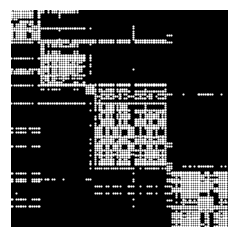

In [7]:
#sns.pairplot(df, hue="species")
from scipy.sparse import coo_matrix
m = np.matrix(filtered[1:])
if not isinstance(m, coo_matrix):
    m = coo_matrix(m)
fig = matplotlib.pyplot.figure()
ax = fig.add_subplot(111, axisbg='black')
ax.plot(m.col, m.row, 's', color='white', ms=1)
ax.set_xlim(0, m.shape[1])
ax.set_ylim(0, m.shape[0])
ax.set_aspect('equal')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.invert_yaxis()
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.figure.show()


# A plot of the excitatory synapse connectivity matrix


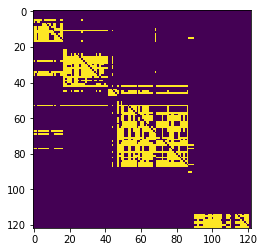

In [8]:
matplotlib.pyplot.imshow(plot_excit)   

# A plot of the inhibitory synapse connectivity matrix


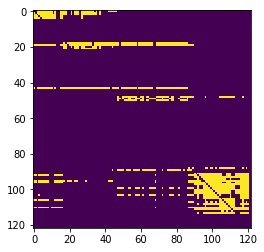

In [9]:
matplotlib.pyplot.imshow(plot_inhib)   


In [10]:
import pyNN.neuron as neuron
from pyNN.neuron import h
from pyNN.neuron import StandardCellType, ParameterSpace


In [11]:
import pyNN
pyNN.neuron.setup(timestep=1.0, min_delay=1.0)

from pyNN.random import RandomDistribution, NumpyRNG
from pyNN.neuron import STDPMechanism, SpikePairRule, AdditiveWeightDependence, FromListConnector, TsodyksMarkramSynapse
from pyNN.neuron import Projection, OneToOneConnector

In [12]:
#from neuron
from numpy import arange
import pyNN
from pyNN.utility import get_simulator, init_logging, normalized_filename
sim = pyNN.neuron
sim.setup(timestep=0.01, min_delay=1.0)
from neuronunit.models.reduced import ReducedModel
from neuronunit.optimization import get_neab

pop_size = len(index_exc)+len(index_inh)


#pop = sim.Population(pop_size, sim.Izhikevich(a=0.02, b=0.2, c=-65, d=6, i_offset=0))
index_exc = [ i for i,d in enumerate(dfm) if '-' in d[0] ]
index_inh = [ i for i,d in enumerate(dfm) if '+' in d[0] ]   
n_exc = len(index_exc)
n_inh = len(index_inh)


from neuronunit.unit_test import Neuronal_Cell
cell_params = Neuronal_Cell.NCell().cell_params
celltype = sim.IF_cond_exp
all_cells = sim.Population(n_exc + n_inh, celltype(**cell_params), label="All Cells")
exc_cells = all_cells[:n_exc]
exc_cells.label = "Excitatory cells"
inh_cells = all_cells[n_exc:]
inh_cells.label = "Inhibitory cells"


injection_values = None       
injection_values = []#[0 for i in pop ]
for i,p in enumerate(all_cells):
    x = int(i/7)
    d = dtcpop[x]
    #attrs = d.attrs
    injection_values.append(d.rheobase['value'])
    #attrs_ = {x:attrs[x] for x in ['a','b','c','d']}
    #p.set_parameters(**attrs_)


Getting Rheobase cached data value for from AIBS dataset 354190013
attempting to recover from pickled file


In [13]:
ohub_index = 0
for x,i in enumerate(plot_excit):
    row_sum = np.sum(i)
    if ohub_index < row_sum:
        ohub_index = x


In [14]:

rng = NumpyRNG(seed=64754)
exc_distr = RandomDistribution('normal', [2.125, 10e-1], rng=rng)
exc_syn = sim.StaticSynapse(weight=exc_distr, delay=delay_distr)
inh_distr = RandomDistribution('normal', [5e-2, 2.1e-3], rng=rng)

inh_syn = sim.StaticSynapse(weight=inh_distr, delay=delay_distr)
rng = NumpyRNG(seed=64754)
delay_distr = RandomDistribution('normal', [50, 100e-3], rng=rng)

# Variation in propogation delays are very important for self sustaininig network activity.
# more so in point neurons which don't have internal propogation times.

stdp = STDPMechanism(
          weight=3.0, #0.02,  # this is the initial value of the weight
          delay="0.2 + 0.01*d",
          timing_dependence=SpikePairRule(tau_plus=20.0, tau_minus=20.0,
                                          A_plus=0.01, A_minus=0.012),
          weight_dependence=AdditiveWeightDependence(w_min=0.01, w_max=10.0))


In [15]:

exc_targets = all_cells[pre_exc] 
exc_srcs = all_cells[post_exc]
inh_srcs = all_cells[pre_inh] # = []
inh_targets = all_cells[post_inh] # = []
conn = OneToOneConnector()
connections = {}
index_exc

exc_cells = all_cells[index_exc]
inh_cells = all_cells[index_inh]

#spike_source = sim.Population(1, sim.SpikeSourcePoisson())
#spike_source.record('spikes')

#connections['e1'] = sim.Projection(spike_source, all_cells, conn , exc_syn, receptor_type='excitatory')
connections['e2'] = sim.Projection(exc_srcs, exc_targets, conn, stdp)
connections['e3'] = sim.Projection(exc_srcs, exc_targets, conn , exc_syn, receptor_type='excitatory')
connections['ie'] = sim.Projection(inh_srcs, inh_targets, conn , inh_syn, receptor_type='inhibitory')


INFO:PyNN:--- Projection[view of 'All Cells' with size 119→view of 'All Cells' with size 84].__init__() ---
INFO:PyNN:--- Projection[view of 'All Cells' with size 119→view of 'All Cells' with size 84].__init__() ---
INFO:PyNN:--- Projection[view of 'All Cells' with size 38→view of 'All Cells' with size 121].__init__() ---


In [16]:
##
# Setup and run a simulation. Note there is no current injection into the neuron.
# All cells in the network are in a quiescent state, so its not a surprise that there are no spikes
##


neurons = all_cells    
sim = pyNN.neuron
arange = np.arange

import re

from pyNN.utility.plotting import Figure, Panel



INFO:PyNN:Initializing membrane potential of 140 cells and 1 Populations.


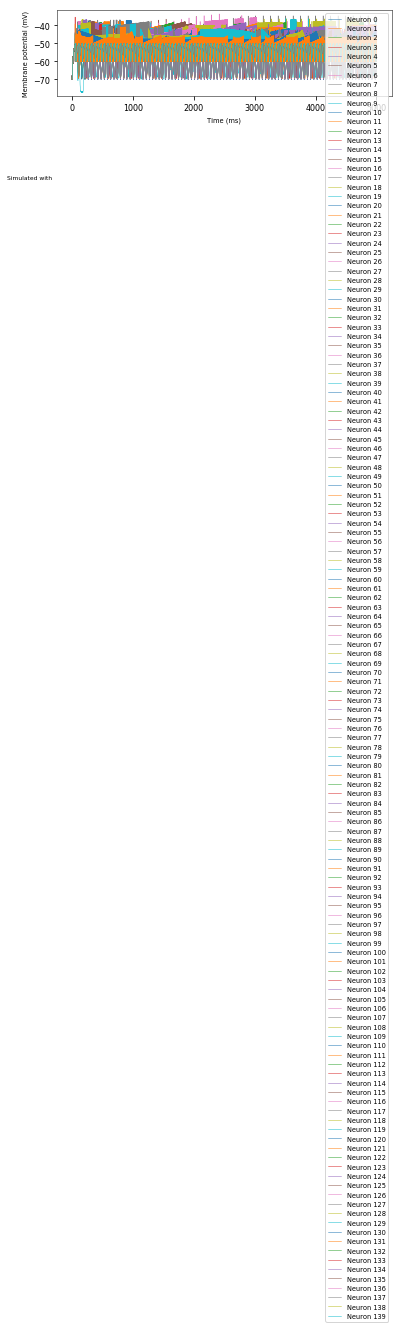

In [17]:



# === Build and instrument the network =======================================

exc_out_hubs = all_cells[ohub_index,92,43,121]
pulses = None
pulses = []


for eoh in exc_out_hubs:
    amps = float(re.sub('\ pA$', '', str(injection_values[eoh])))  
    amplitude=0.014
    p0 = sim.DCSource(amplitude = amps, start=50.0, stop=145.0)
    p0.inject_into(all_cells[(eoh,)])    
    pulses.append(p0)


neurons.record(['v','spikes'])  # , 'u'])
neurons.initialize(v=-70.0, u=-14.0)


# === Run the simulation =====================================================

sim.run(5000.0)


from pyNN.utility.plotting import Figure, Panel, comparison_plot, plot_spiketrains
data = neurons.get_data().segments[0]
v = data.filter(name="v")[0]
Figure(
    Panel(v, ylabel="Membrane potential (mV)", xticks=True,
          xlabel="Time (ms)", yticks=True),
    #Panel(u, ylabel="u variable (units?)"),
    annotations="Simulated with" 
)



In [18]:
import pickle

data = neurons.get_data().segments[0]
with open('membrane_dynamics_hippocampome_file.p', 'wb') as f:
    pickle.dump(data,f)
#data = neurons.get_data().segments[0]
v0 =  neurons[(0,)].get_data().segments[0].filter(name="v")[0]
v1 =  neurons[(1,)].get_data().segments[0].filter(name="v")[0]


Below are plots of post synaptic targets in the from an arbitary source cell in the Entorhinal cortex, to targets taht are also in the EC.

'\nFigure(\n    comparison_plot(data.filter(name="v")[:], labels="neurons")\n    #, ylabel="Membrane potential (mV)", xticks=True,\n    #      xlabel="Time (ms)", yticks=True),\n    #Panel(u, ylabel="u variable (units?)"),\n    #annotations="Simulated with" \n)\n'

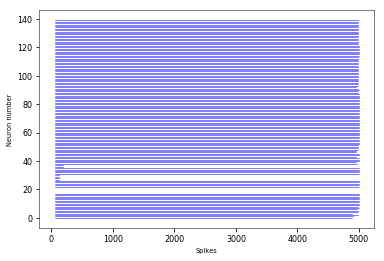

In [19]:
# Plot spike trains
import matplotlib.pyplot as plt

def plot_spiketrains(segment):
  """
  Plots the spikes of all the cells in the given segments
  """
  for spiketrain in segment.spiketrains:
      y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
      plt.plot(spiketrain, y, 'b')
      plt.ylabel('Neuron number')
      plt.xlabel('Spikes')
        
spikes = neurons.get_data("spikes").segments[0]
data = neurons.get_data().segments[0]
#print(data.spiketrains)
plot_spiketrains(data)


'''
Figure(
    comparison_plot(data.filter(name="v")[:], labels="neurons")
    #, ylabel="Membrane potential (mV)", xticks=True,
    #      xlabel="Time (ms)", yticks=True),
    #Panel(u, ylabel="u variable (units?)"),
    #annotations="Simulated with" 
)
'''


# === Clean up and quit ========================================================
#spikes = pop.get_data("spikes").segments[0]
#data = pop.get_data().segments[0]
#print(data.spiketrains)


#sim.end()


#print(spikes)
#m
#print(plt.backend)
#ax.figure.show()
#fig.savefig('connection_matrix.png')
#from IPython.display import Image
#Image(filename='connection_matrix.png') 
#df
#targets
#pd.DataFrame(targets).plot.hist()
#for k,v in targets.items():
#  pd.DataFrame(v).plot.hist()
#df

In [20]:
#Image(filename='connection_matrix.png') 


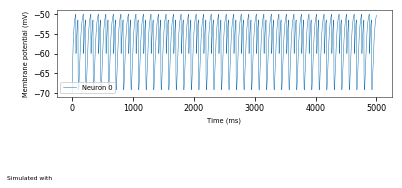

In [21]:



#u = data.filter(name="u")[0]
Figure(
    Panel(v0, ylabel="Membrane potential (mV)", xticks=True,
          xlabel="Time (ms)", yticks=True),
    #Panel(u, ylabel="u variable (units?)"),
    annotations="Simulated with" 
)



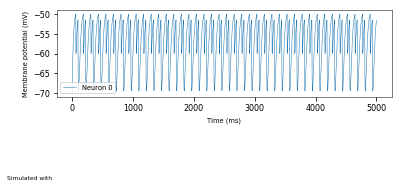

In [22]:

#u = data.filter(name="u")[0]
Figure(
    Panel(v1, ylabel="Membrane potential (mV)", xticks=True,
          xlabel="Time (ms)", yticks=True),
    #Panel(u, ylabel="u variable (units?)"),
    annotations="Simulated with" 
)





```
# This is formatted as code
```

